# 1) Setup colab GPU runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 6.9 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=6188a6bce117f4964f180d6b13d104c3b1a67d724fa405a8798edb2dd22b744a
  Stored in directory: /root/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=4b772859b7db1f1c3fcf4b0cb8dcc0f9c1a11dfd936c9af7023e37815cac7fb6
  Stored in directory: /root/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_ckgljc9
  Running command git clone --filter=blob:no

# 1.1. Download Dataset


In [2]:
!git clone https://github.com/balarcode/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 999, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 999 (delta 31), reused 12 (delta 8), pack-reused 953 (from 1)
Receiving objects: 100% (999/999), 24.68 MiB | 23.42 MiB/s, done.
Resolving deltas: 100% (97/97), done.


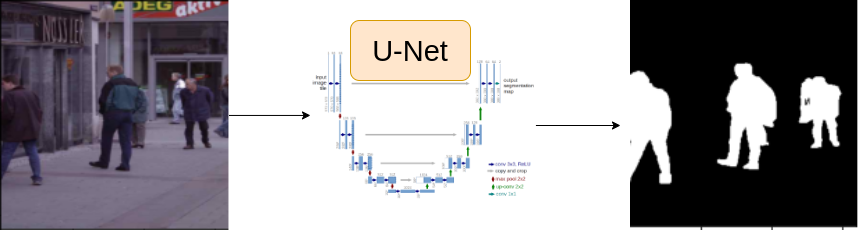

# 1.2. Common Imports

In [3]:
import sys
sys.path.append('/content/deep-learning/computer_vision/image_segmentation/data')

In [4]:
import torch # PyTorch library
import cv2 # OpenCV library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 2) Setup Configuration

In [5]:
CSV_FILE = '/content/deep-learning/computer_vision/image_segmentation/data/training.csv'
DATA_DIR = '/content/deep-learning/computer_vision/image_segmentation/data/'

DEVICE = 'cuda' # GPU will be used for execution

EPOCHS = 25
LR = 0.003 # Learning Rate
IMAGE_SIZE = 320 # Height = Width
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
# Plot the image
df = pd.read_csv(CSV_FILE) # Data frame
df.head() # 'masks' are the target images (i.e. segments) and 'images' are the original input images

,masks,images
0,ground_truth/1.png,training_images/1.jpg
1,ground_truth/10.png,training_images/10.jpg
2,ground_truth/100.png,training_images/100.jpg
3,ground_truth/101.png,training_images/101.jpg
4,ground_truth/102.png,training_images/102.jpg


In [7]:
row = df.iloc[1]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image to RGB format

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 # mask image will be a grayscale image and it is converted to a black and white image

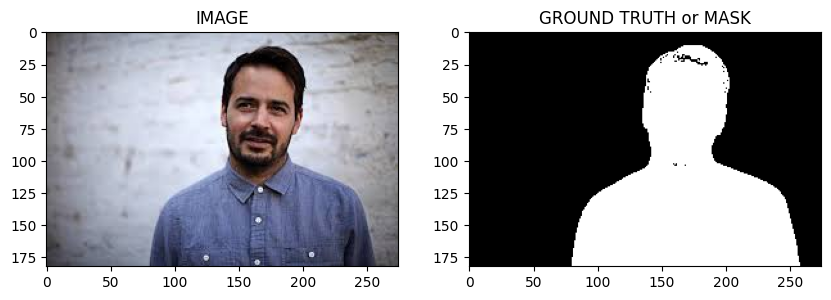

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH or MASK')
ax2.imshow(mask, cmap = 'gray')

In [9]:
# Split the data set into training and validation data sets
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# 3) Augmentation Functions

In [10]:
# Augmentation brings certain transformations to the image dataset. Image augmentation is a process of creating new training examples from the existing ones in order to
# improve the quality and performance of the deep neural network.
# Albumentations library is used for image augmentation and it can be applied to a variety of datasets for image segmentation, image object detection, image classification, etc.
# For image segmentation data sets, any application of augmentation brings the same effect to both original and ground truth or mask images.
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5), # 50% chance that the image will be flipped horizontally
      A.VerticalFlip(p = 0.5) # 50% chance that the image will be flipped vertically
      ], is_check_shapes=False)

def get_validate_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      ], is_check_shapes=False)

# 4) Create Custom Dataset

In [12]:
# Custom data set is created to obtain an image-mask pair for the given index
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # image format = (height, width, channel) = axis(0, 1, 2)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # image format = (height, width, channel) = axis(0, 1, 2)
    mask = np.expand_dims(mask, axis = -1)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) # This will return the mask and image as a dictionary
      image = data['image']
      mask = data['mask']
    # Change the format of the images to (channel, height, width)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # 2, 0, 1 are the axis labeled for the input image and they are being reordered using transpose()
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
    # Convert the images in numpy to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0) # Round the pixel values to either 0 or 1
    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validateset = SegmentationDataset(valid_df, get_validate_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validateset)}")

Size of Trainset : 232
Size of Validset : 58


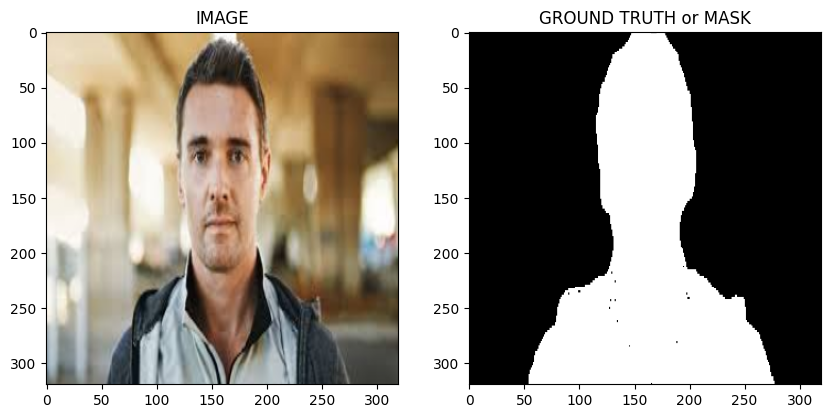

In [16]:
idx = 32

image, mask = trainset[idx]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze())

ax2.set_title('GROUND TRUTH or MASK')
ax2.imshow(mask.permute(1,2,0).squeeze(), cmap = 'gray')

# 5) Load Dataset into Batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) # At every Epoch, the batches get shuffled if 'shuffle' parameter is set to True
validloader = DataLoader(validateset, batch_size=BATCH_SIZE)

In [19]:
print(f"Total number of batches in trainloader: {len(trainloader)}") # Ceil(training set size / batch size)
print(f"Total number of batches in validloader: {len(validloader)}") # Ceil(validation set size / batch size)

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# 6) Create Segmentation Model

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    # Unet segmentation model is used; Unet is convolution neural network for image semantic segmentation
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, # R G B channels
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks) # Binary cross entropy with logits loss
      return logits, loss1 + loss2
    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE) # Move to and run model on GPU using CUDA

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 97.6MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# 7) Create Training and Validation Functions

In [24]:
def training(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad() # Set gradients to be zeros
    logits, loss = model(images, masks) # Run the model (i.e. image segmentation model previously defined)
    loss.backward() # Compute gradients w.r.t the loss function; Do a backward pass
    optimizer.step() # Update the weights resulting in a gradient descent

    total_loss += loss.item()
  return total_loss / len(data_loader) # Return the average loss by dividing total_loss by number of batches

In [25]:
def validation(data_loader, model):
  model.eval() # Avoids using any dropout layer(s)
  total_loss = 0.0

  with torch.no_grad(): # Disable gradient computation
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  return total_loss / len(data_loader) # Return the average loss by dividing total_loss by number of batches


# 8) Train the Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [27]:
best_validation_loss = np.Inf # Set to infinity initially

for i in range(EPOCHS):
  train_loss = training(trainloader, model, optimizer)
  valid_loss = validation(validloader, model)
  if (valid_loss < best_validation_loss):
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model Saved!")
    best_validation_loss = valid_loss

  print(f"Epoch: {i+1}, Training loss: {train_loss}, Validation loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]


Model Saved!
Epoch: 1, Training loss: 0.7940532823403676, Validation loss: 1.916385143995285


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Model Saved!
Epoch: 2, Training loss: 0.3789344191551208, Validation loss: 0.3768259361386299


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Model Saved!
Epoch: 3, Training loss: 0.324093688527743, Validation loss: 0.32446835190057755


100%|██████████| 4/4 [00:00<00:00,  6.12it/s]


Model Saved!
Epoch: 4, Training loss: 0.30449743469556173, Validation loss: 0.2607058845460415


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


Epoch: 5, Training loss: 0.2954163193702698, Validation loss: 0.295630618929863


100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Model Saved!
Epoch: 6, Training loss: 0.23013438085714977, Validation loss: 0.24243315309286118


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Model Saved!
Epoch: 7, Training loss: 0.24974510073661804, Validation loss: 0.23557164892554283


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch: 8, Training loss: 0.18049423297246298, Validation loss: 0.24590623378753662


100%|██████████| 4/4 [00:00<00:00,  6.15it/s]


Model Saved!
Epoch: 9, Training loss: 0.2103730211655299, Validation loss: 0.19597415253520012


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch: 10, Training loss: 0.20673455397288004, Validation loss: 0.24996764585375786


100%|██████████| 4/4 [00:00<00:00,  5.97it/s]


Epoch: 11, Training loss: 0.16830467681090036, Validation loss: 0.21184008195996284


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Model Saved!
Epoch: 12, Training loss: 0.13670576413472493, Validation loss: 0.1724143587052822


100%|██████████| 4/4 [00:00<00:00,  6.08it/s]


Epoch: 13, Training loss: 0.13738028158744175, Validation loss: 0.21262553706765175


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch: 14, Training loss: 0.13056533932685851, Validation loss: 0.18818650022149086


100%|██████████| 4/4 [00:00<00:00,  6.05it/s]


Model Saved!
Epoch: 15, Training loss: 0.12212034265200297, Validation loss: 0.1683455277234316


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch: 16, Training loss: 0.12532319525877636, Validation loss: 0.17314552888274193


100%|██████████| 4/4 [00:00<00:00,  6.00it/s]


Epoch: 17, Training loss: 0.12042823135852813, Validation loss: 0.22795052081346512


100%|██████████| 4/4 [00:01<00:00,  2.54it/s]


Epoch: 18, Training loss: 0.11301521211862564, Validation loss: 0.1721008513122797


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]


Epoch: 19, Training loss: 0.09902043392260869, Validation loss: 0.18146933615207672


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch: 20, Training loss: 0.11029878854751587, Validation loss: 0.2039662003517151


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch: 21, Training loss: 0.10465611418088278, Validation loss: 0.2063693404197693


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch: 22, Training loss: 0.11340571691592534, Validation loss: 0.22503787279129028


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch: 23, Training loss: 0.12497598926226298, Validation loss: 0.21571438759565353


100%|██████████| 4/4 [00:00<00:00,  6.01it/s]


Epoch: 24, Training loss: 0.1370431239406268, Validation loss: 0.27450457215309143


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]

Epoch: 25, Training loss: 0.1482859159509341, Validation loss: 0.24410999566316605


# 9) Inference

In [28]:
# Inference using best saved model i.e. best_model.pt
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validateset[idx] # image tensor has shape of (channel, height, width)

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze to add the batch dimension so that image tensor's shape becomes (1, channel, height, width)

predicted_mask = torch.sigmoid(logits_mask) # Apply sigmoid activation
predicted_mask = (predicted_mask > 0.5)*1.0

<ipython-input-28-fffd2d898af3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


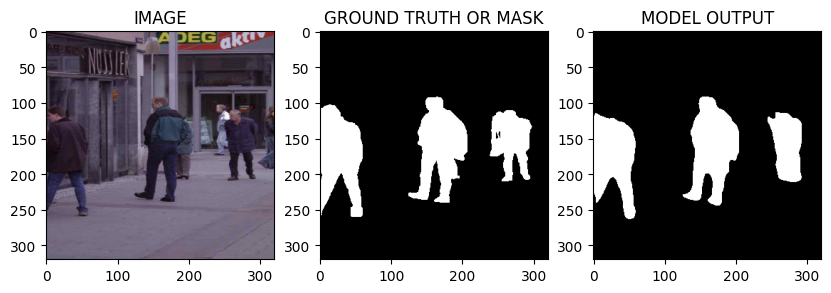

In [29]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

ax2.set_title('GROUND TRUTH OR MASK')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

ax3.set_title('MODEL OUTPUT')
predicted_mask = predicted_mask.detach().cpu().squeeze(0)
ax3.imshow(predicted_mask.permute(1,2,0).squeeze(),cmap = 'gray')

In [30]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validateset[idx] # image tensor has shape of (channel, height, width)

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze to add the batch dimension so that image tensor's shape becomes (1, channel, height, width)

predicted_mask = torch.sigmoid(logits_mask) # Apply sigmoid activation
predicted_mask = (predicted_mask > 0.5)*1.0

<ipython-input-30-fcc7e3591c8b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


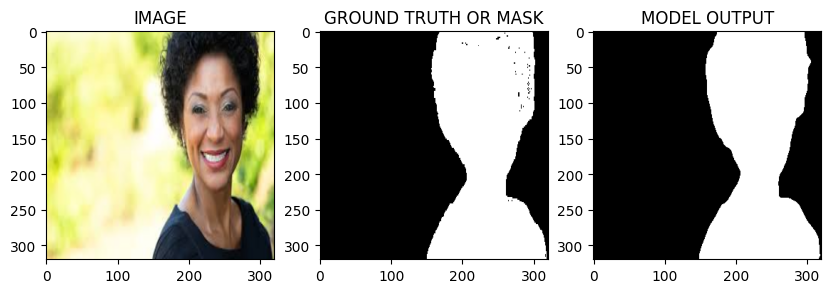

In [31]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

ax2.set_title('GROUND TRUTH OR MASK')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

ax3.set_title('MODEL OUTPUT')
predicted_mask = predicted_mask.detach().cpu().squeeze(0)
ax3.imshow(predicted_mask.permute(1,2,0).squeeze(),cmap = 'gray')